In [3]:
import pandas as pd
import scipy
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils.generators import UserGenerator

In [2]:
%matplotlib inline

In [3]:
# A simple generator to simulate userdata
ug = UserGenerator(column_label='Clickthrough Rate')

In [4]:
# creating a dataframe prelabeled for AB testing
# the outcome will contain 2 groups, A with a success rate of 12% B with a success rate of 10 % . 
df = ug.generate_ab_split_df(nr_of_users=4000,positive_ratio_A=0.12, positive_ratio_B=0.1, nr_of_days=5,AB_user_ratio=0.5)

In [5]:
# looking at the data
df.head(2)

,user_id,Clickthrough Rate,datetime,group
0,uid_3622,0,2020-01-02 22:48:17,A
1,uid_3623,0,2020-01-05 07:21:03,A


In [6]:
# creating a label to make a more visual plot
df['hour'] =  df.datetime.dt.day.astype(str) + df.datetime.dt.hour.astype(str)

[Text(0, 0.5, 'Häufigkeit'), Text(0.5, 0, 'Clickthrough Rate')]

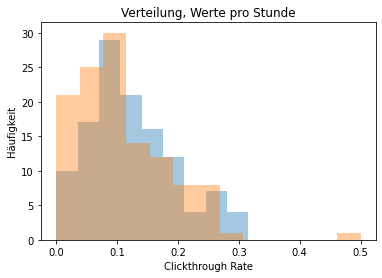

In [7]:
# Plot the hour grouped mean clickthrogh distribution
ax = sns.distplot(df.loc[df.group == 'A'].groupby(['hour'])['Clickthrough Rate'].mean(), kde=False)
ax = sns.distplot(df.loc[df.group == 'B'].groupby(['hour'])['Clickthrough Rate'].mean(), kde=False)
ax.set_title('Verteilung, Werte pro Stunde')
ax.set(xlabel='Clickthrough Rate', ylabel='Häufigkeit')

In [8]:
# NOT THE RIGHT WAY !
# simplest approaches with wrong / questionable assumptions.
# let's assume normal distributed means. 
# all we need are the means and standard deviations 

# compare with Unpaired t- test.  Unpaired because the two datasets are not paired up.
df.groupby('group')['Clickthrough Rate'].mean()
df.groupby('group')['Clickthrough Rate'].std()

group
A    0.326789
B    0.308554
Name: Clickthrough Rate, dtype: float64

In [9]:
group_A_modelassumptions = np.random.normal(loc = df.loc[df.group == 'A']['Clickthrough Rate'].mean()
                 , scale=df.loc[df.group == 'A']['Clickthrough Rate'].std()
                 , size =100 )

group_B_modelassumptions = np.random.normal(loc = df.loc[df.group == 'B']['Clickthrough Rate'].mean()
                 , scale=df.loc[df.group == 'A']['Clickthrough Rate'].std()
                 , size =100 )

[Text(0, 0.5, 'Häufigkeit'), Text(0.5, 0, 'Clickthrough Rate')]

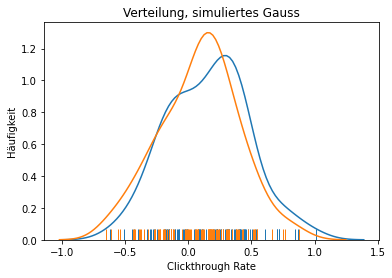

In [10]:
# Plot what the model assumes is happening :
ax = sns.distplot(group_A_modelassumptions, kde=True, hist=False, rug=True)
ax = sns.distplot(group_B_modelassumptions, kde=True, hist=False, rug= True)
ax.set_title('Verteilung, simuliertes Gauss')
ax.set(xlabel='Clickthrough Rate', ylabel='Häufigkeit')

In [11]:
t_statistic, p_value = scipy.stats.ttest_ind(df.loc[df.group=='A']['Clickthrough Rate'],df.loc[df.group=='B']['Clickthrough Rate'] )

In [12]:
# t statistic
t_statistic

1.4925687225092465

In [13]:
# p value
p_value #  this is above 0.05   so we assume there is no difference between A and B

0.135629019684456

In [14]:
# proper assumptions Binomial Distribution
# Fischers Exact test 

In [6]:
# 2X2 contingency table
def create_contingency(df):
    """
    create a contingency table
    """
    contingency = {'A': {'0': df.loc[df.group=='A'].shape[0] - df.loc[df.group=='A']['Clickthrough Rate'].sum() 
                     
                     ,'1': df.loc[df.group=='A']['Clickthrough Rate'].sum() 
                    }
               
               ,'B': {'0': df.loc[df.group=='B'].shape[0] - df.loc[df.group=='B']['Clickthrough Rate'].sum() 
                     
                     ,'1': df.loc[df.group=='B']['Clickthrough Rate'].sum() 
                    }
              }
    return pd.DataFrame.from_dict(contingency)



contingency_table = create_contingency(df)

NameError: name 'df' is not defined

In [16]:
contingency_table

,A,B
0,1757,1787
1,243,213


In [17]:
oddsratio, pvalue = scipy.stats.fisher_exact(table=contingency_table)

In [18]:
pvalue

0.14902065412035642

Under the assumption that a 20% lift is significant,  
lets test how many sample we need to reliably get the right answer

In [5]:


def simulate_ABtest(data_generator, nr_of_users,  lift ):
    """
    takes the 
    
    sample generator: UserGenerator OBJECT, 
    nr_of_users INT : number of requested users and 
    lift FLOAT : requested lift
    
    returns:
    p values pair
    
    calculate the p values for the Gaussian (wrong) and Binomial (right) distribution
    
    """
    dat = data_generator.generate_ab_split_df(nr_of_users=nr_of_users
                                              ,positive_ratio_A=0.1
                                              ,positive_ratio_B=0.1 + lift
                                              ,nr_of_days=5 # not relevant here
                                              ,AB_user_ratio=0.5 ) # euqual sized groups )
    
    t_statistic, p_value_norm = scipy.stats.ttest_ind(dat.loc[dat.group=='A']['Clickthrough Rate'],
                                                 dat.loc[dat.group=='B']['Clickthrough Rate'] )
                                                                                        
    contingency = create_contingency(dat)
    ddsratio, p_value_binom = scipy.stats.fisher_exact(table=contingency)
    
    return p_value_norm, p_value_binom

In [20]:
%time simulate_ABtest(ug, 100,0.1)

CPU times: user 16.2 ms, sys: 1.29 ms, total: 17.5 ms
Wall time: 14.4 ms


(0.11225471615692119, 0.1997170794013246)

In [34]:
# simulate sensitivitiy to sample size

sample_sizes = [n*10 for n in range(1,800) ]

p_values_samples_sizes = {}


for samle_size in tqdm(sample_sizes):
    _, p_val = simulate_ABtest(ug, samle_size ,0.02)
    p_values_samples_sizes[samle_size] = p_val


100%|██████████| 799/799 [01:24<00:00,  9.42it/s]


In [35]:
simulate_ABtest(ug, 10000 ,0.02)

(0.18565265068662976, 0.19655597130614333)

In [36]:
dat = pd.DataFrame.from_dict({'pval':p_values_samples_sizes}, orient='columns')

In [37]:
dat.reset_index(inplace=True)

[Text(0, 0.5, 'p-Value'), Text(0.5, 0, 'Zahl der Proben')]

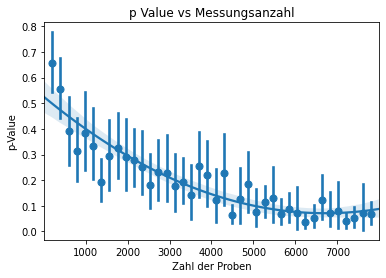

In [48]:
ax = sns.regplot(x='index',y='pval', data=dat, x_bins=40,order=2)
ax.set_title("p Value vs Messungsanzahl")
ax.set(xlabel='Zahl der Proben', ylabel='p-Value')

In [49]:
# Extend investigation into the lift axis

In [25]:
%time a,b = simulate_ABtest(ug, 8000, .2)

CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 177 ms


In [26]:
((177.8 * 31920 ) / 1000) 

5675.376

In [31]:
len(users) * len(lifts)

31920

In [ ]:
# Add also the dimension of lift to test

lifts = np.linspace(0,.2,num=80) # between 0 and 30% increase
users = [n*200 for n in range(1, 400)]  # 100 to 10000 users
repetitions = 1

count = 0

p_val_norm = pd.DataFrame()
p_val_binom = pd.DataFrame()


for lift in lifts:
    for user in users:
        #for repetition in range(repetitions):
            count +=1
            
            if count % 100 == 0:
                print(count)
            
            pn, pb = simulate_ABtest(ug, user,lift)
            
#            p_val_norm_dict[f'{lift}-{user}-{repetition}'] = pn
#            p_val_binom_dict[f'{lift}-{user}-{repetition}'] = pb
            
            
            p_val_norm = p_val_norm.append(pd.Series({'lift':lift, 'users':user,'rep': repetition, 'pval':pn}),ignore_index=True )
            p_val_binom = p_val_norm.append(pd.Series({'lift':lift, 'users':user,'rep':repetition, 'pval':pb}),ignore_index=True )

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500


In [28]:
count

31920

In [157]:
#p_val_binom.to_csv('pvalues_binom_table.csv')
#p_val_norm.to_csv('pvalues_norm_table.csv')

In [4]:
p_val_binom = pd.read_csv('../pvalues_binom_table.csv', index_col=0)
p_val_norm = pd.read_csv('../pvalues_norm_table.csv', index_col=0)

In [5]:
p_val_norm.head()

,lift,pval,rep,users
0,0.0,0.752258,0.0,100.0
1,0.0,0.509884,1.0,100.0
2,0.0,0.466042,2.0,100.0
3,0.0,0.769005,3.0,100.0
4,0.0,0.466042,4.0,100.0


In [6]:
from mpl_toolkits.mplot3d import Axes3D

In [7]:
p_val_binom.head(1)

,lift,pval,rep,users
0,0.0,0.752258,0.0,100.0


In [8]:
p_val_binom = p_val_binom.loc[p_val_binom.users < 8000]
p_val_binom = p_val_binom.loc[p_val_binom.lift < 0.2]

p_val_norm = p_val_norm.loc[p_val_norm.users < 8000]
p_val_norm = p_val_norm.loc[p_val_norm.lift < 0.2]

In [14]:
def plot_pval(value):
    if value < 0.05:
        return value * 10
    return value 

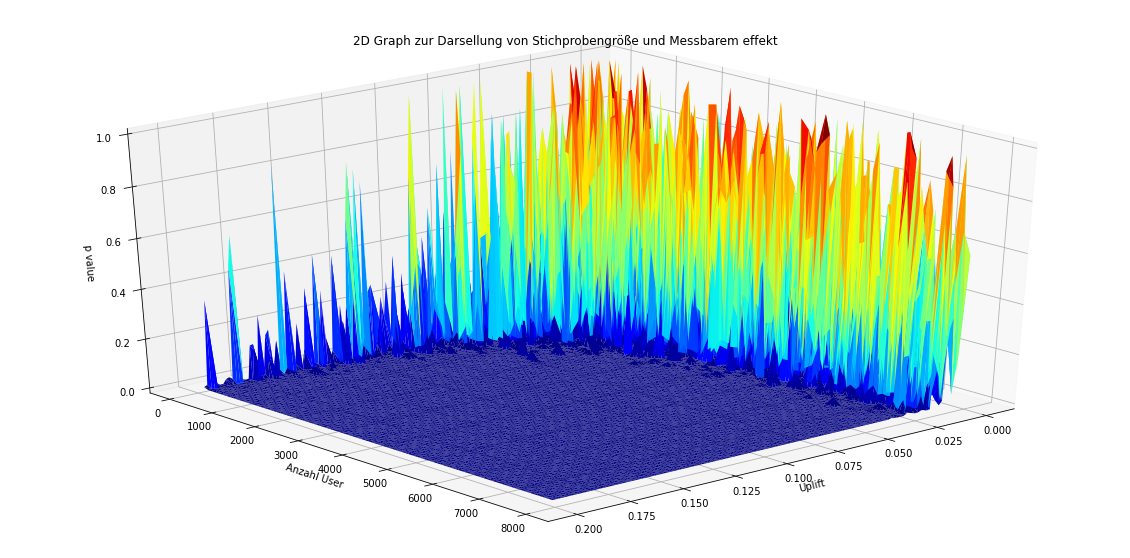

In [17]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
# Other palette
ax.plot_trisurf(p_val_binom['lift'],p_val_binom['users'], p_val_binom['pval'], cmap=plt.cm.jet, linewidth=0.01)

ax.set_title("2D Graph zur Darsellung von Stichprobengröße und Messbarem effekt") 
ax.set(xlabel='Uplift', ylabel='Anzahl User',zlabel='p value')
# Rotate it
ax.view_init(30, 49)

#ax.set_zscale(plot_pval)

plt.show()

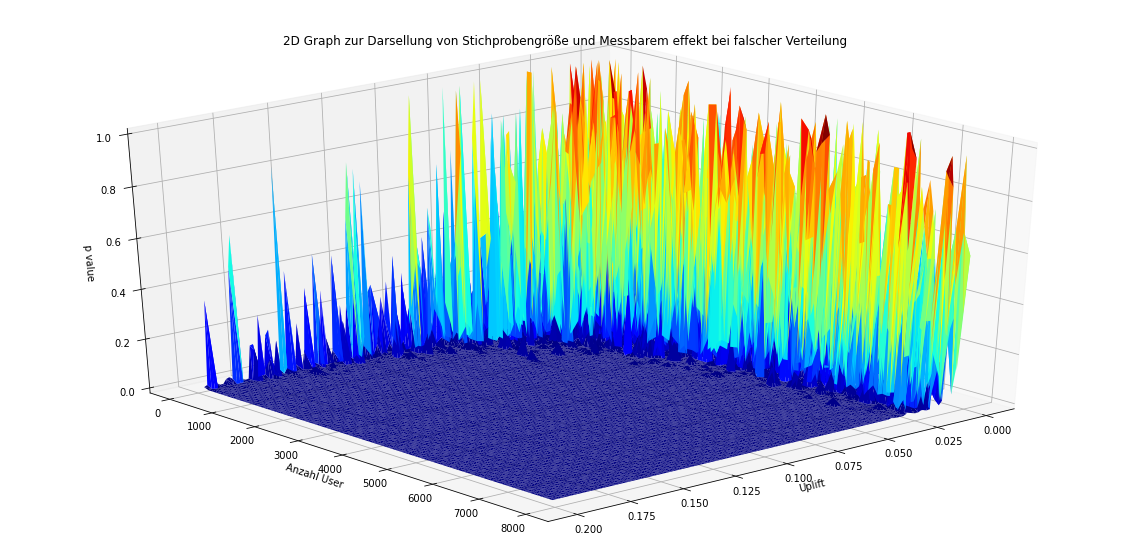

In [88]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
# Other palette
ax.plot_trisurf(p_val_norm['lift'],p_val_norm['users'], p_val_norm['pval'], cmap=plt.cm.jet, linewidth=0.01)

ax.set_title("2D Graph zur Darsellung von Stichprobengröße und Messbarem effekt bei falscher Verteilung") 
ax.set(xlabel='Uplift', ylabel='Anzahl User',zlabel='p value')
# Rotate it
ax.view_init(30, 49)

plt.show()

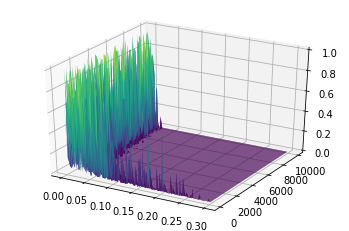

In [68]:
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(p_val_binom['lift'], p_val_binom['users'], p_val_binom['pval'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(p_val_binom['lift'], p_val_binom['users'], p_val_binom['pval'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
#ax.zaxis._set_scale('log')
plt.show()
 
# Rotate it
ax.view_init(130, 5)
plt.show()
 
# Other palette
ax.plot_trisurf(p_val_binom['lift'],p_val_binom['users'], p_val_binom['pval'], cmap=plt.cm.jet, linewidth=0.01)
ax.zaxis._set_scale('log')
plt.show()

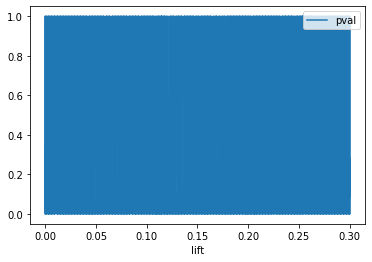

In [154]:
p_val_norm.plot(kind='line',x='lift', y='pval')

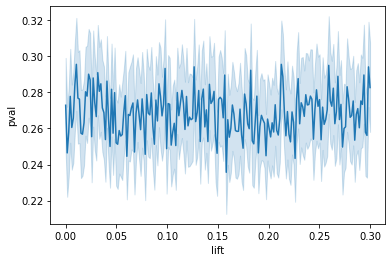

In [155]:
sns.lineplot(x="lift", y="pval", data=p_val_norm)

In [138]:
p_val_binom.loc['']

,lift,pval,rep,users
0,0.0,0.029176,0.0,100.0
1,0.0,0.206349,1.0,100.0
2,0.0,1.000000,2.0,100.0
3,0.0,0.429601,3.0,100.0
4,0.0,0.021674,4.0,100.0
...,...,...,...,...
98996,0.3,0.029176,1.0,9900.0
98997,0.3,0.466447,2.0,9900.0
98998,0.3,0.136334,3.0,9900.0
98999,0.3,0.279874,4.0,9900.0
